## PCA and distance matrix in PLINK 1.90

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

The first pass is based on the workflow outlined here: https://speciationgenomics.github.io/pca/

In [55]:
%%bash
module load plink/1.90
plink --vcf /scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredSNPs.recode.vcf.gz \
--double-id \
--allow-extra-chr \
--set-missing-var-ids @:# \
--indep-pairwise 50 10 0.1 \
--out /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes

plink --vcf /scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredSNPs.recode.vcf.gz \
--double-id \
--allow-extra-chr \
--set-missing-var-ids @:# \
--extract /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.prune.in \
--make-bed --pca --out /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes

PLINK v1.90b6.20 64-bit (21 Sep 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --indep-pairwise 50 10 0.1
  --out /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes
  --set-missing-var-ids @:#
  --vcf /scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredSNPs.recode.vcf.gz

385441 MB RAM detected; reserving 192720 MB for main workspace.
Allocated 8138 MB successfully, after larger attempt(s) failed.
--vcf: /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes-temporary.bed +
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes-temporary.bim +
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes-temporary.fam written.
883354 variants loaded from .bim file.
883354 missing IDs set.
48 people (0 males, 0 females, 48 ambiguous) loaded from .fam.
Ambiguous sex I

plink  1.90  environment loaded 


### Graphical output

In [56]:
# Population map:
species, loc, sample, pop = [], [], [], []
with open("/scratch/project_2000913/Penguins/Macaroni/MacaroniGenomesPop.csv") as ifile:
    next(ifile)
    for i in ifile:
        row = i.strip("\n").split(",")
        species.append(row[0])
        loc.append(row[1])
        pop.append(row[5])
        sample.append(row[3])
        
speciesDict = dict(zip(sample, species))
locDict = dict(zip(sample, loc))
popDict = dict(zip(sample, pop))

In [57]:
def plotPLINK(path, pc=[1,2]):
    
    # Load eigenvalues and make a screeplot
    eigenvals = []
    with open(path + ".eigenval") as ifile:
        for i in ifile:
            eigenvals.append(float(i.strip('\n')))

    percentVar = [round(e/sum(eigenvals), 4)*100 for e in eigenvals]
    plt.rcParams['figure.figsize'] = [12, 4]
    plt.plot([x for x in range(len(percentVar))], percentVar, ls='--')
    plt.scatter([x for x in range(len(percentVar))], percentVar, s=40)
    plt.scatter([x-1 for x in pc], [percentVar[x-1] for x in pc], c='r')
    plt.xticks([x for x in range(len(percentVar))], ["PC"+str(x+1) for x in range(len(percentVar))], rotation=20)
    plt.ylabel("% variance explained")
    plt.show()
    
    # Load eigenvectors:
    nPC = len(eigenvals)
    names, PC = [], []
    for i in range(nPC):
        PC.append([])

    with open(path + ".eigenvec") as ifile:
        for i in ifile:
            row = i.strip("\n").split(" ")
            names.append(row[0])
            row = row[2:]
            for k in range(nPC):
                PC[k].append(float(row[k]))
                
    # Make up a Pandas dataframe with all the data:
    df = pd.DataFrame(zip(names, [speciesDict[x] for x in names], [locDict[x] for x in names], PC[0], PC[1], PC[2], PC[3], PC[4]))
    df.columns = ['sample', 'species', 'loc', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5']
    
    # Plot:
    plt.rcParams['figure.figsize'] = [12, 12]
    sns.scatterplot(x='PC'+str(pc[0]), y='PC'+str(pc[1]), data=df, hue='loc', style='species', alpha=.75, s=250)
    plt.axhline(0, c='k', ls='--', lw=.75)
    plt.axvline(0, c='k', ls='--', lw=.75)
    for i in range(len(names)):
        plt.text(PC[pc[0]-1][i], PC[pc[1]-1][i], names[i], fontsize=8)
    plt.show()

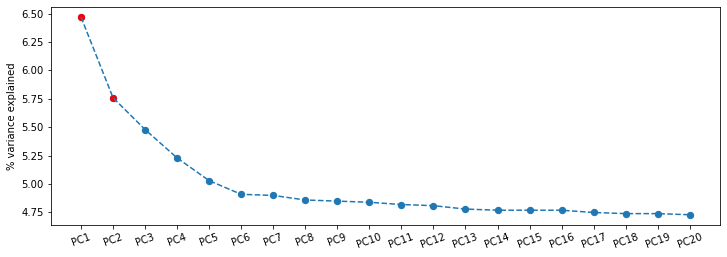

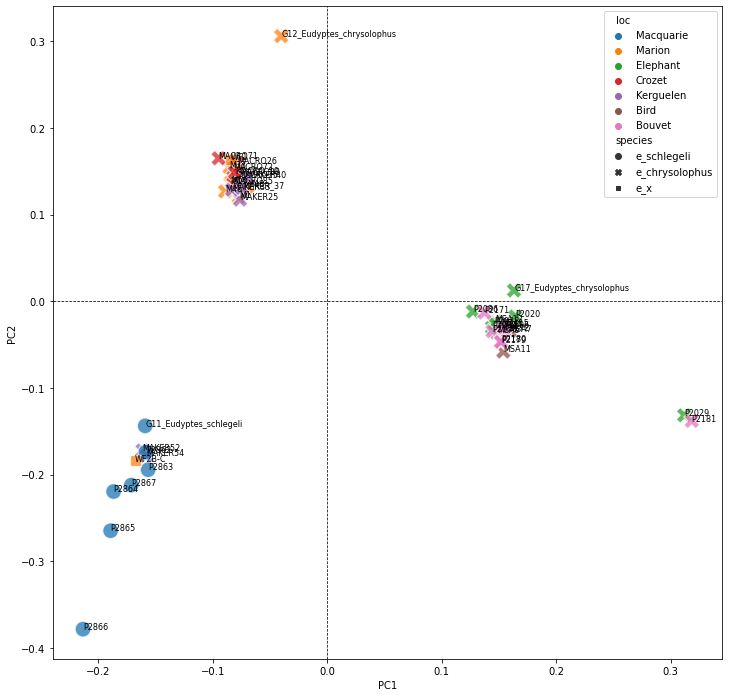

In [58]:
plotPLINK("/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes", [1,2])

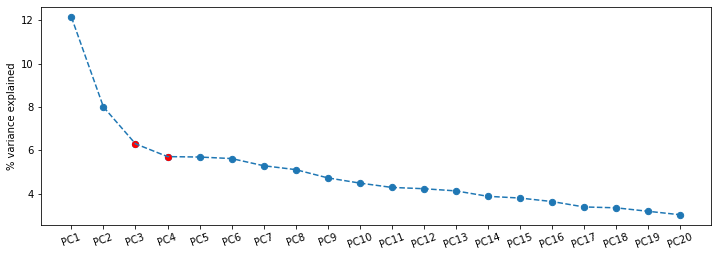

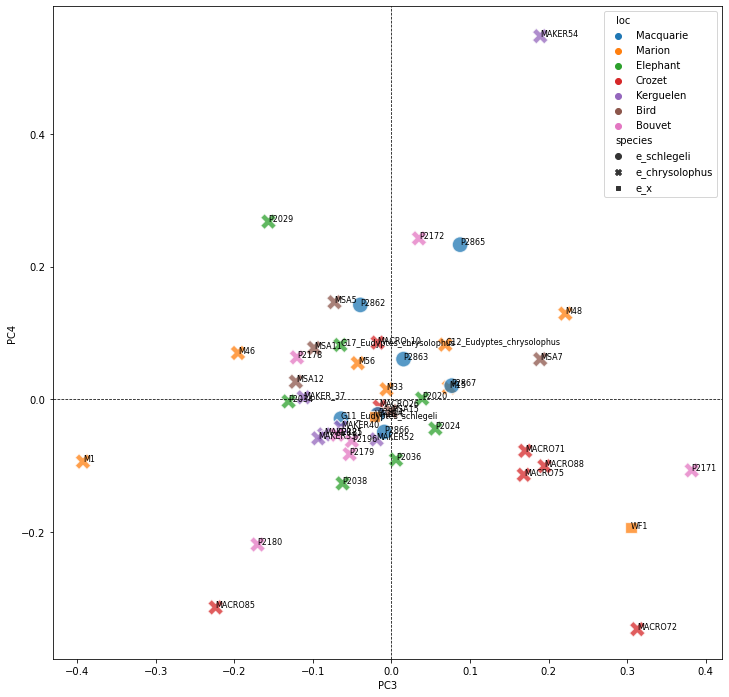

In [32]:
plotPLINK("/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes", [3,4])

## Close-up on the Atlantic and Indian areas

In [28]:
pop, sample = [], []
with open("/users/cristofa/scratch/Penguins/Macaroni/MacaroniGenomesPop.csv") as ifile:
    next(ifile)
    for line in ifile:
        i = line.strip("\n").split(",")
        pop.append(i[5])
        sample.append(i[3])

with open("/users/cristofa/scratch/Penguins/Macaroni/PLINK/atlantic.list", "w") as ofile: 
        for s in [x for i, x in enumerate(sample) if pop[i] == "atlantic"]:
            ofile.write(s + "\t" + s + "\n")
            
with open("/users/cristofa/scratch/Penguins/Macaroni/PLINK/indian.list", "w") as ofile: 
        for s in [x for i, x in enumerate(sample) if pop[i] == "indian"]:
            ofile.write(s + "\t" + s + "\n")

In [29]:
%%bash
module load plink/1.90
plink --vcf /scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredSNPs.recode.vcf.gz \
--double-id \
--keep /users/cristofa/scratch/Penguins/Macaroni/PLINK/atlantic.list \
--allow-extra-chr \
--set-missing-var-ids @:# \
--indep-pairwise 50 10 0.1 \
--out /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.atlantic

PLINK v1.90b6.20 64-bit (21 Sep 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.atlantic.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --indep-pairwise 50 10 0.1
  --keep /users/cristofa/scratch/Penguins/Macaroni/PLINK/atlantic.list
  --out /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.atlantic
  --set-missing-var-ids @:#
  --vcf /scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredSNPs.recode.vcf.gz

385441 MB RAM detected; reserving 192720 MB for main workspace.
Allocated 8138 MB successfully, after larger attempt(s) failed.
--vcf:
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.atlantic-temporary.bed
+
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.atlantic-temporary.bim
+
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.atlantic-temporary.fam
written.
883354 variants loaded fr

plink  1.90  environment loaded 


In [30]:
%%bash
module load plink/1.90
plink --vcf /scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredSNPs.recode.vcf.gz \
--double-id \
--keep /users/cristofa/scratch/Penguins/Macaroni/PLINK/atlantic.list \
--allow-extra-chr \
--set-missing-var-ids @:# \
--extract /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.prune.in \
--make-bed --pca --out /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.atlantic

PLINK v1.90b6.20 64-bit (21 Sep 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.atlantic.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --extract /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.prune.in
  --keep /users/cristofa/scratch/Penguins/Macaroni/PLINK/atlantic.list
  --make-bed
  --out /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.atlantic
  --pca
  --set-missing-var-ids @:#
  --vcf /scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredSNPs.recode.vcf.gz

385441 MB RAM detected; reserving 192720 MB for main workspace.
Allocated 8138 MB successfully, after larger attempt(s) failed.
--vcf:
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.atlantic-temporary.bed
+
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.atlantic-temporary.bim
+
/users/cristofa/scratch/Penguins/Macaroni/PL

plink  1.90  environment loaded 


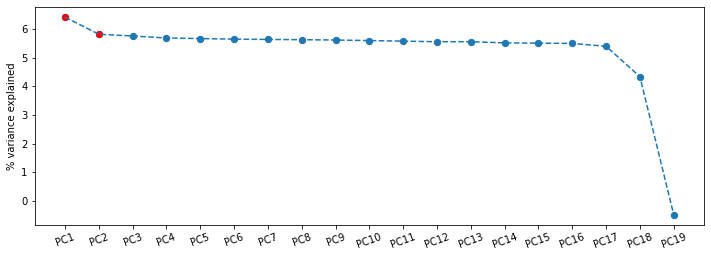

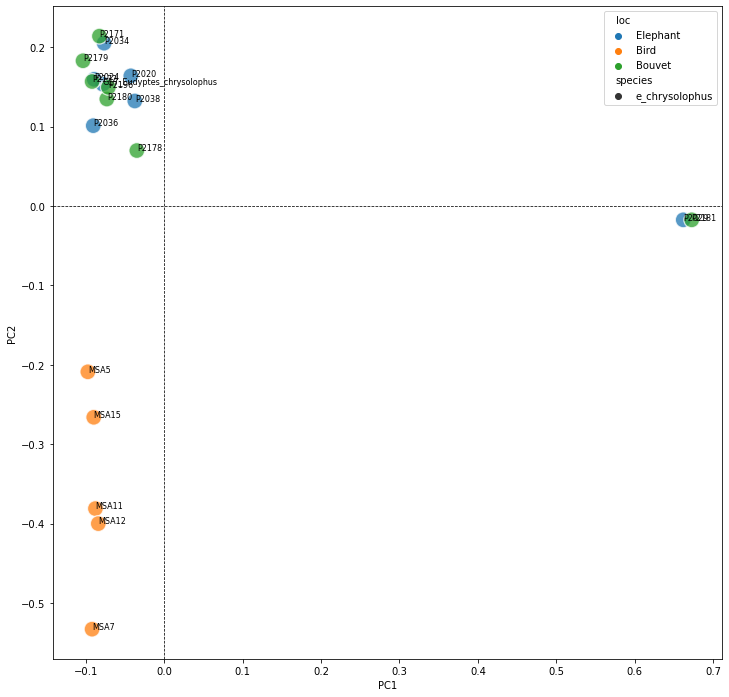

In [33]:
plotPLINK("/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.atlantic", [1,2])

In [42]:
%%bash
module load plink/1.90
plink --vcf /scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredSNPs.recode.vcf.gz \
--double-id \
--keep /users/cristofa/scratch/Penguins/Macaroni/PLINK/indian.list \
--allow-extra-chr \
--set-missing-var-ids @:# \
--indep-pairwise 50 10 0.1 \
--out /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.indian

PLINK v1.90b6.20 64-bit (21 Sep 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.indian.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --indep-pairwise 50 10 0.1
  --keep /users/cristofa/scratch/Penguins/Macaroni/PLINK/indian.list
  --out /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.indian
  --set-missing-var-ids @:#
  --vcf /scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredSNPs.recode.vcf.gz

385441 MB RAM detected; reserving 192720 MB for main workspace.
Allocated 8138 MB successfully, after larger attempt(s) failed.
--vcf:
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.indian-temporary.bed +
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.indian-temporary.bim +
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.indian-temporary.fam
written.
883354 variants loaded from .bim file

plink  1.90  environment loaded 


In [43]:
%%bash
module load plink/1.90
plink --vcf /scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredSNPs.recode.vcf.gz \
--double-id \
--keep /users/cristofa/scratch/Penguins/Macaroni/PLINK/indian.list \
--allow-extra-chr \
--set-missing-var-ids @:# \
--extract /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.prune.in \
--make-bed --pca --out /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.indian

PLINK v1.90b6.20 64-bit (21 Sep 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.indian.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --extract /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.prune.in
  --keep /users/cristofa/scratch/Penguins/Macaroni/PLINK/indian.list
  --make-bed
  --out /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.indian
  --pca
  --set-missing-var-ids @:#
  --vcf /scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredSNPs.recode.vcf.gz

385441 MB RAM detected; reserving 192720 MB for main workspace.
Allocated 8138 MB successfully, after larger attempt(s) failed.
--vcf:
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.indian-temporary.bed +
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.indian-temporary.bim +
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudypt

plink  1.90  environment loaded 


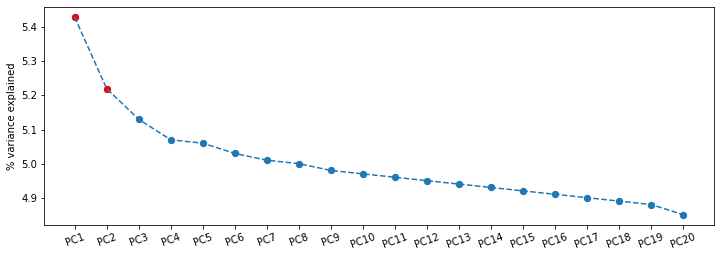

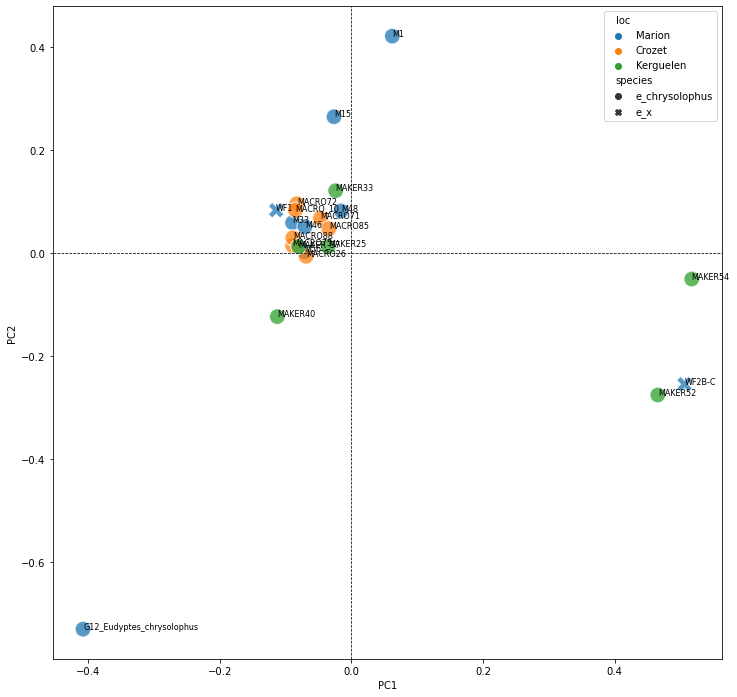

In [34]:
plotPLINK("/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.indian", [1,2])

### Look only at Scaffold19:

In [1]:
%%bash
module load plink/1.90
plink --vcf /scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredSNPs.recode.vcf.gz \
--double-id \
--allow-extra-chr \
--set-missing-var-ids @:# \
--indep-pairwise 50 10 0.1 \
--chr Scaffold19 \
--out /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.scaf19

PLINK v1.90b6.20 64-bit (21 Sep 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.scaf19.log.
Options in effect:
  --allow-extra-chr
  --chr Scaffold19
  --double-id
  --indep-pairwise 50 10 0.1
  --out /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.scaf19
  --set-missing-var-ids @:#
  --vcf /scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredSNPs.recode.vcf.gz

385441 MB RAM detected; reserving 192720 MB for main workspace.
Allocated 8138 MB successfully, after larger attempt(s) failed.
--vcf:
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.scaf19-temporary.bed +
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.scaf19-temporary.bim +
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.scaf19-temporary.fam
written.
(881080 variants skipped.)
2274 variants loaded from .bim file.
2274 missing IDs set.
4

plink  1.90  environment loaded 


In [6]:
%%bash
module load plink/1.90
plink --vcf /scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredSNPs.recode.vcf.gz \
--double-id \
--allow-extra-chr \
--set-missing-var-ids @:# \
--chr Scaffold19 \
--extract /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.scaf19.prune.in \
--make-bed --pca --out /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.scaf19

PLINK v1.90b6.20 64-bit (21 Sep 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.scaf19.log.
Options in effect:
  --allow-extra-chr
  --chr Scaffold19
  --double-id
  --extract /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.scaf19.prune.in
  --make-bed
  --out /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.scaf19
  --pca
  --set-missing-var-ids @:#
  --vcf /scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredSNPs.recode.vcf.gz

385441 MB RAM detected; reserving 192720 MB for main workspace.
Allocated 8138 MB successfully, after larger attempt(s) failed.
--vcf:
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.scaf19-temporary.bed +
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.scaf19-temporary.bim +
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.scaf19-temporary.fam
written.
(881080 va

plink  1.90  environment loaded 


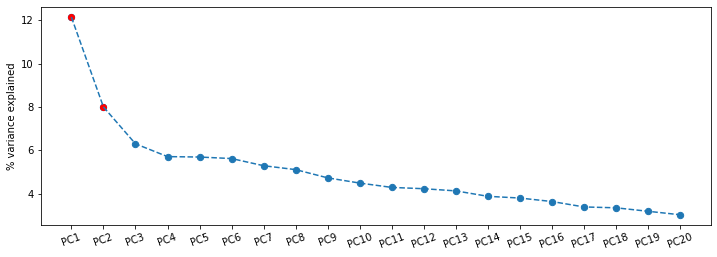

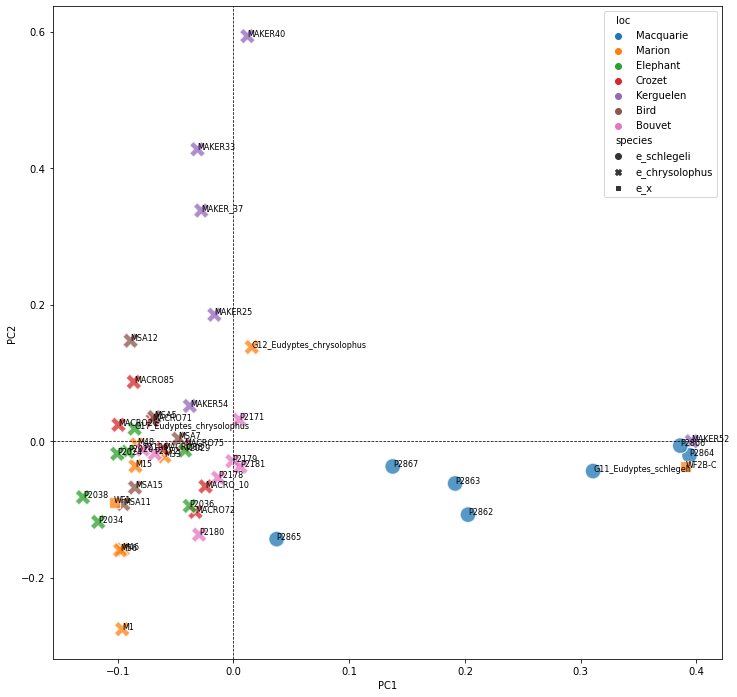

In [35]:
plotPLINK("/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.scaf19", [1,2])

### Scaffold 54:

In [38]:
%%bash
module load plink/1.90
plink --vcf /scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredSNPs.recode.vcf.gz \
--double-id \
--allow-extra-chr \
--set-missing-var-ids @:# \
--indep-pairwise 50 10 0.1 \
--chr Scaffold54 \
--out /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.scaf54

plink --vcf /scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredSNPs.recode.vcf.gz \
--double-id \
--allow-extra-chr \
--set-missing-var-ids @:# \
--chr Scaffold54 \
--extract /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.scaf54.prune.in \
--make-bed --pca --out /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.scaf54

PLINK v1.90b6.20 64-bit (21 Sep 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.scaf54.log.
Options in effect:
  --allow-extra-chr
  --chr Scaffold54
  --double-id
  --indep-pairwise 50 10 0.1
  --out /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.scaf54
  --set-missing-var-ids @:#
  --vcf /scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredSNPs.recode.vcf.gz

385441 MB RAM detected; reserving 192720 MB for main workspace.
Allocated 8138 MB successfully, after larger attempt(s) failed.
--vcf:
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.scaf54-temporary.bed +
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.scaf54-temporary.bim +
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.scaf54-temporary.fam
written.
(860002 variants skipped.)
23352 variants loaded from .bim file.
23352 missing IDs set.

plink  1.90  environment loaded 


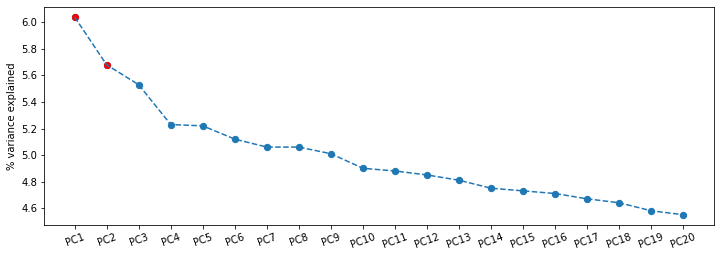

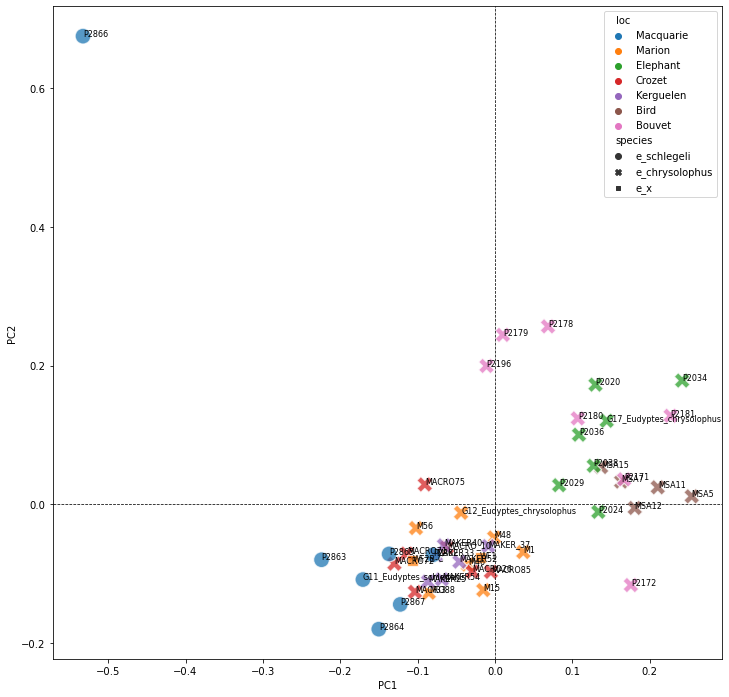

In [62]:
plotPLINK("/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.scaf54", [1,2])

## PCA on InDel sites:

In [51]:
%%bash
module load plink/1.90
plink --vcf /scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredInDels.recode.vcf \
--double-id \
--allow-extra-chr \
--set-missing-var-ids @:# \
--indep-pairwise 50 10 0.1 \
--out /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.InDels

plink --vcf /scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredInDels.recode.vcf \
--double-id \
--allow-extra-chr \
--set-missing-var-ids @:# \
--extract /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.InDels.prune.in \
--make-bed --pca --out /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.InDels

PLINK v1.90b6.20 64-bit (21 Sep 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.InDels.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --indep-pairwise 50 10 0.1
  --out /users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.InDels
  --set-missing-var-ids @:#
  --vcf /scratch/project_2000913/Penguins/Macaroni/vcf/eudyptes_filteredInDels.recode.vcf

385441 MB RAM detected; reserving 192720 MB for main workspace.
Allocated 8138 MB successfully, after larger attempt(s) failed.
--vcf:
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.InDels-temporary.bed +
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.InDels-temporary.bim +
/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.InDels-temporary.fam
written.
81197 variants loaded from .bim file.
81197 missing IDs set.
48 people (0 males, 0 females, 48 ambiguous) l

plink  1.90  environment loaded 


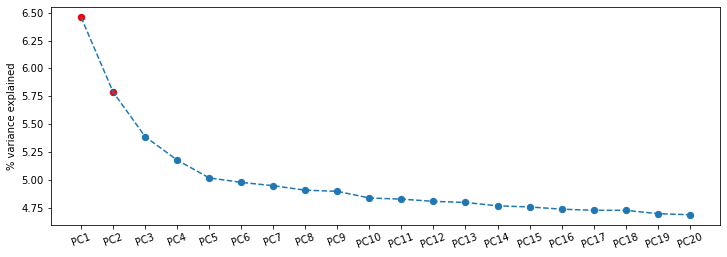

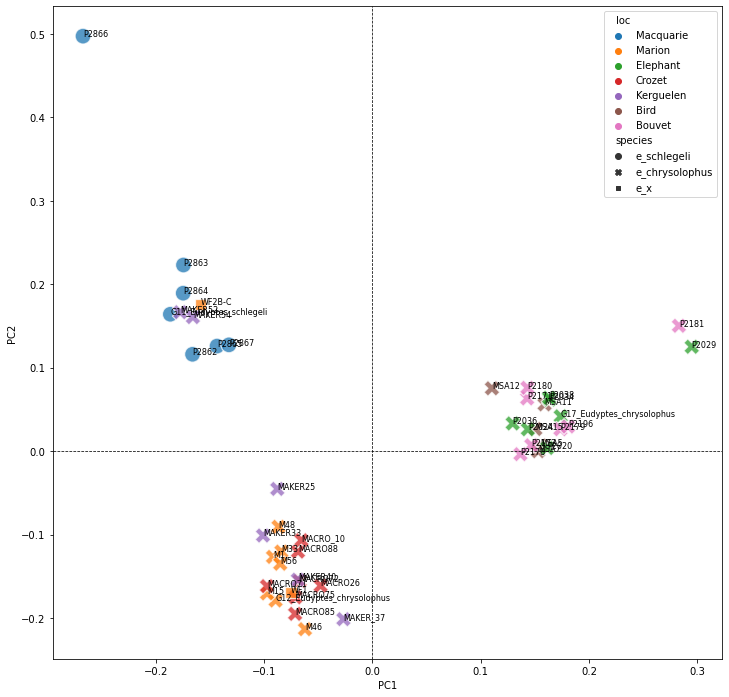

In [52]:
plotPLINK("/users/cristofa/scratch/Penguins/Macaroni/PLINK/eudyptes.InDels", [1,2])